## Imports & Configuration

In [10]:
import numpy as np
import scipy.io.wavfile as wav
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import glob
import joblib
import sklearn
import sys
from pydub import AudioSegment
import python_speech_features as psf
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import scipy.stats

# Configuration Parameters
DATA_DIRS = {
    "Men": "dataAMINA/data/men/",
    "Women": "dataAMINA/data/women/"
}
MODELS_GAUSSIAN = "GMM_Nederlands/"
MODELS_DIR = "trained_models/"
NO_SILENCE_FOLDER = 'dataAMINA/no_silence/'
NO_SILENCE_FOLDER_MEN = 'dataAMINA/no_silence/men/'
NO_SILENCE_FOLDER_WOMEN = 'dataAMINA/no_silence/women/'
if not os.path.exists(MODELS_GAUSSIAN): os.makedirs(MODELS_GAUSSIAN)
if not os.path.exists(MODELS_DIR): os.makedirs(MODELS_DIR)
if not os.path.exists(NO_SILENCE_FOLDER):os.makedirs(NO_SILENCE_FOLDER)
if not os.path.exists(NO_SILENCE_FOLDER_MEN):os.makedirs(NO_SILENCE_FOLDER_MEN)
if not os.path.exists(NO_SILENCE_FOLDER_WOMEN):os.makedirs(NO_SILENCE_FOLDER_WOMEN)

# MFCC Parameters
NUM_CEP = 13
WIN_FUNC = np.hamming

# GMM Components to study
N_COMPONENTS_LIST = [4, 8, 16, 32, 64, 128, 256, 512]

print("Configuration Loaded.")

Configuration Loaded.


## Version Check

In [11]:
print("Python Version:", sys.version)
print("-" * 30)
print(f"Scikit-Learn Version: {sklearn.__version__}")
print(f"Joblib Version:       {joblib.__version__}")
print("-" * 30)

if sklearn.__version__ == "1.7.2":
    print("✅ You are using the NEW version.")
else:
    print("⚠️ You are NOT using 1.7.2 yet.")
    print("   Please click 'Kernel' -> 'Restart' in your menu.")

Python Version: 3.12.6 (tags/v3.12.6:a4a2d2b, Sep  6 2024, 20:11:23) [MSC v.1940 64 bit (AMD64)]
------------------------------
Scikit-Learn Version: 1.7.2
Joblib Version:       1.4.2
------------------------------
✅ You are using the NEW version.


## The Feature Extractor (Batch Processor)

In [12]:
def get_clean_features_from_folder(folder_path, label):
    # CHANGE 1: Look for .flac files instead of .wav
    # (If you have a mix, you can use "*.wav" or "*.flac")
    audio_files = glob.glob(os.path.join(folder_path, "*.wav"))

    if not audio_files:
        print(f"Warning: No .wav files found in {folder_path}")
        return None

    all_features = []
    print(f"--- Processing {label} ({len(audio_files)} files) with HYBRID logic ---")

    for file_path in audio_files:
        try:
            # CHANGE 2: Use Librosa to read FLAC
            # sr=None ensures we keep the original sample rate (e.g., 44.1kHz or 16kHz)
            signal, sr = librosa.load(file_path, sr=None)

            # Handle Stereo (Librosa usually loads as Mono by default, but just in case)
            if len(signal.shape) > 1:
                signal = signal[0] # Take first channel

            # 2. Extract MFCCs
            n_fft = 1024 if sr <= 16000 else 2048
            mfccs = psf.mfcc(signal, sr, numcep=NUM_CEP, nfft=n_fft, winfunc=WIN_FUNC, appendEnergy=False)

            # Skip very short files
            if len(mfccs) < 10: continue

            # 3. Silence Removal (K-Means)
            # Note: Librosa signals are small floats (-1 to 1), so energies will be small numbers.
            # This is fine; K-Means adapts automatically.
            energies = np.sum(np.square(mfccs), axis=1).reshape(-1, 1)

            # Train KMeans
            kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0)
            kmeans.fit(energies)
            kmeans_centers = kmeans.cluster_centers_.ravel()

            # Train GMM
            gmm = GaussianMixture(n_components=2, random_state=42, init_params="k-means++")
            gmm.fit(energies)
            gmm_means = gmm.means_.ravel()

            # Calculate Hybrid Threshold (Professor's Logic)
            # Average of the MINIMUMS (Silence centers) of both methods
            threshold = (np.min(gmm_means) + np.min(kmeans_centers)) / 2

            # Create Mask
            is_speech = (energies > threshold).flatten()

            # 4. Keep only speech frames
            clean_mfcc = mfccs[is_speech]
            if len(clean_mfcc) < 2: continue

            # Add Deltas
            deltas = psf.delta(clean_mfcc, 2)
            features = np.hstack((clean_mfcc, deltas))

            all_features.append(features)

            # ==============================================================================
            # # A. GMM
            # gmm = GaussianMixture(n_components=2, random_state=42, init_params="k-means++")
            # gmm.fit(energies)
            # means_gmm = gmm.means_.ravel()
            # labels_gmm = gmm.predict(energies)

            # silence_idx_gmm = np.argmin(means_gmm)
            # speech_idx_gmm = 1 - silence_idx_gmm
            # mask_gmm = (labels_gmm == speech_idx_gmm)
            # seuil_gmm = (means_gmm[0] + means_gmm[1]) / 2

            # # B. K-MEANS
            # kmeans = KMeans(n_clusters=2, n_init='auto', random_state=0)
            # kmeans.fit(energies)
            # centers_km = kmeans.cluster_centers_.ravel()
            # labels_km = kmeans.labels_

            # silence_idx_km = np.argmin(centers_km)
            # speech_idx_km = 1 - silence_idx_km
            # mask_km = (labels_km == speech_idx_km)
            # seuil_km = (centers_km[0] + centers_km[1]) / 2

            # # C. HYBRIDE
            # seuil_hybrid = (means_gmm[silence_idx_gmm] + centers_km[silence_idx_km]) / 2 + \
            #               (means_gmm[speech_idx_gmm] - means_gmm[silence_idx_gmm]) * 0.1
            # mask_hybrid = (energies.ravel() > seuil_hybrid)
            # ==============================================================================

            # --- NEW: SAVE AUDIO WITHOUT SILENCE ---

            # 1. Map frame mask to audio samples
            win_len_samples = int(0.025 * sr) # Default 25ms
            win_step_samples = int(0.01 * sr) # Default 10ms stride

            audio_mask = np.zeros(len(signal), dtype=bool)
            for i, speech_flag in enumerate(is_speech):
                if speech_flag:
                    start = i * win_step_samples
                    end = start + win_len_samples
                    if end > len(signal): end = len(signal)
                    audio_mask[start:end] = True

            clean_signal = signal[audio_mask]

            # 2. Construct Filename (Change .flac to .wav)
            filename = os.path.basename(file_path)
            filename_wav = os.path.splitext(filename)[0] + ".wav"
            save_path = os.path.join(f"{NO_SILENCE_FOLDER}{label.lower()}/", filename_wav)

            # 3. Save
            wav.write(save_path, sr, clean_signal)

        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    # Stack all files together
    if all_features:
        combined_features = np.vstack(all_features)
        print(f"-> Finished {label}. Collected {len(combined_features)} frames of speech.")
        return combined_features
    else:
        return None

## Training Loop & "The Study"

In [13]:
# Container for all features from all folders
all_features_list = []

# 1. Collect Data from ALL folders
print("--- Phase 1: Data Collection ---")
for label, path in DATA_DIRS.items():
    print(f"Processing folder: {label}...")
    # Extract features using your function
    features = get_clean_features_from_folder(path, label)

    if features is not None:
        all_features_list.append(features)

# 2. Combine into one giant dataset
if len(all_features_list) > 0:
    combined_features = np.vstack(all_features_list)
    print(f"\n-> TOTAL DATASET: {len(combined_features)} frames (Men + Women combined)")
else:
    raise ValueError("No data collected from any folder!")

# 3. Run the "Study" on the Combined Data
print(f"\n--- Phase 2: Training Combined Models ---")

results = {} # To store data for plotting
label = "Combined_Men_Women"
bic_scores = []
trained_models = {}

for n in N_COMPONENTS_LIST:
    # Safety check: Do we have enough data?
    if len(combined_features) < n * 2:
        print(f"Skipping n={n} (Not enough data)")
        bic_scores.append(np.nan)
        continue

    print(f" Training GMM with n={n}...", end=" ")

    # Train GMM on the combined data
    gmm = GaussianMixture(n_components=n,
                          covariance_type='diag',
                          max_iter=100,
                          random_state=42,
                          verbose=2)
    gmm.fit(combined_features)

    # Calculate Score
    score = gmm.bic(combined_features)
    bic_scores.append(score)
    trained_models[n] = gmm
    # print(f"Done. BIC: {score:.0f}")

    # --- NEW STEP: Save THIS specific component model immediately ---
    filename_specific = os.path.join(MODELS_GAUSSIAN, f"GMM_Nederlands_{n}.gmm")
    joblib.dump(gmm, filename_specific)
    print(f"  -> Saved intermediate model to: {filename_specific}")
    # ---------------------------------------------------------------

# 4. Find Best Model
# Filter NaNs
valid_scores = [s for s in bic_scores if not np.isnan(s)]
valid_n = [N_COMPONENTS_LIST[i] for i, s in enumerate(bic_scores) if not np.isnan(s)]

best_idx = np.argmin(valid_scores)
best_n = valid_n[best_idx]
best_model = trained_models[best_n]

# Save Results for plotting
results[label] = {
    "n": valid_n,
    "bic": valid_scores,
    "best_n": best_n
}

# 5. Save the Single Combined Model to Disk
filename_best = os.path.join(MODELS_DIR, f"GMM_Nederlands_Best.gmm")
joblib.dump(best_model, filename_best)
print(f"\n-> Saved Nederlands Model (n={best_n}) to {filename_best}")

print("\n--- Training Complete ---")

--- Phase 1: Data Collection ---
Processing folder: Men...
--- Processing Men (540 files) with HYBRID logic ---
-> Finished Men. Collected 84265 frames of speech.
Processing folder: Women...
--- Processing Women (181 files) with HYBRID logic ---
-> Finished Women. Collected 128987 frames of speech.

-> TOTAL DATASET: 213252 frames (Men + Women combined)

--- Phase 2: Training Combined Models ---
 Training GMM with n=4... Initialization 0
  Iteration 10	 time lapse 1.69497s	 ll change 0.00592
Initialization converged. time lapse 2.47979s	 lower bound -93.14763.
  -> Saved intermediate model to: GMM_Nederlands/GMM_Nederlands_4.gmm
 Training GMM with n=8... Initialization 0
  Iteration 10	 time lapse 2.01865s	 ll change 0.00352
Initialization converged. time lapse 2.77480s	 lower bound -91.76741.
  -> Saved intermediate model to: GMM_Nederlands/GMM_Nederlands_8.gmm
 Training GMM with n=16... Initialization 0
  Iteration 10	 time lapse 3.85126s	 ll change 0.00358
  Iteration 20	 time lapse

## Visualization for the Combined Model

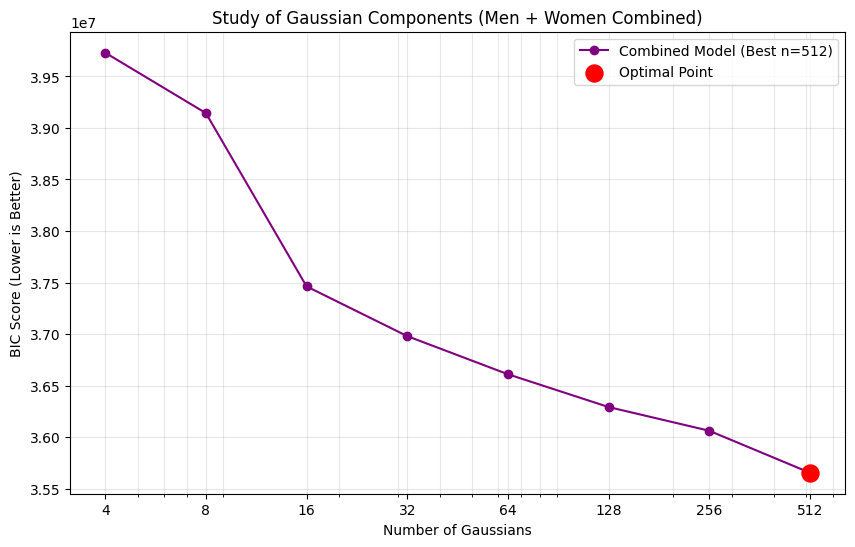

In [14]:
plt.figure(figsize=(10, 6))

data = results["Combined_Men_Women"]
valid_n = data["n"]
valid_scores = data["bic"]
best_n = data["best_n"]

# Plot curve
plt.plot(valid_n, valid_scores, marker='o', linestyle='-', color='purple', label=f"Combined Model (Best n={best_n})")

# Highlight best point
best_score_idx = valid_n.index(best_n)
plt.scatter(best_n, valid_scores[best_score_idx], s=150, c='red', zorder=5, label="Optimal Point")

plt.title("Study of Gaussian Components (Men + Women Combined)")
plt.xlabel("Number of Gaussians")
plt.ylabel("BIC Score (Lower is Better)")
plt.xscale('log')
plt.xticks(N_COMPONENTS_LIST, labels=N_COMPONENTS_LIST)
plt.grid(True, which="both", ls="-", alpha=0.3)
plt.legend()
plt.show()